<a href="https://colab.research.google.com/github/KyuhyoJeon/SimCLR/blob/main/SimCLR_%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 목표: SimCLR single GPU 구현
# 2. dataset: cifar10
# 3. ResNet18 variant(cifar10) (https://github.com/PatrickHua/SimSiam)
# 4. Data augmentation (data loader)
# 5. Non-linear Projection Head (256 256)
# 6. Linear Evaluation (Contrastive Learning method -> Evaluation -> FC (ResNet backbone Freeze)) (https://github.com/spijkervet/byol)
# 7. Optimizer (Adam, SGD, LARS)
# 8. single GPU에서는 Batchsize가 작게 밖에안되서 성능이 안 좋을 거에요 (60%)
# 9. KNN Moniotoring (optional) -> debugging용 (validation set으로 accuracy 사용하는 것처럼. 하지만 FC가 없으므로 feature간의 KNN을 이용하는 방법)

파라미터

In [ ]:
# parameters
name = 'simclr-cifar10-experiment'
dataset_name = 'cifar10'
image_size = 32
num_workers = 4
model_name = 'simclr'
model_backbone = 'resnet18'
train_optim_weight_decay = 1.e-6
train_warmup_epochs = 10
train_warmup_lr = 0
train_base_lr = 0.3
train_final_lr = 0
train_num_epochs = 800
train_stop_at_epoch = 100
batch_size = 256
train_knn_monitor = False
train_knn_interval = 1
train_knn_k = 200
eval_optim_name = 'sgd'
eval_optim_weight_decay = 0
eval_optim_momentum = 0.9
eval_warmup_lr = 0
eval_warmup_epochs = 0
eval_base_lr = 30
eval_final_lr = 0
eval_num_epochs = 30
logger_tensorboard = True
logger_matplotlib = True
seed = None
config_file_name = 'simclr.yaml'

download = True
data_dir = './data'
log_dir = './runs'
ckpt_dir = './tmp'
device = 'cuda'
eval_from = None
hide_progress = False


debug = False
do_eval = True
dryrun = True
train_optim_name = 'lars'


debug_subset_size = 8 if debug else None

CIFAR10 로드 및 SimCLR 형식으로 전처리

In [ ]:
# 데이터 호출 및 Pre-processing
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchvision.transforms import GaussianBlur

# try:
#   from torchvision.transforms import GaussianBlur
# except ImportError:
#   from .gaussian_blur import GaussianBlur
#   transforms.GaussianBlur = GaussianBlur

imagenet_mean_std = [[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]]

class SimCLRTransform():
  def __init__(self, size, mean_std=imagenet_mean_std, s=1.0):
    size = 224 if size is None else size 
    self.transform = transforms.Compose([
        transforms.RandomResizedCrop(size, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply(
            [transforms.ColorJitter(0.8*s,0.8*s,0.8*s,0.2*s)], p=0.8
            ),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply(
            [transforms.GaussianBlur(
                kernel_size=size//20*2+1, sigma=(0.1, 2.0)
                )], p=0.5
            ),
        # We blur the image 50% of the time using a Gaussian kernel. 
        # We randomly sample σ ∈ [0.1, 2.0], and the kernel size is 
        # set to be 10% of the image height/width.
        transforms.ToTensor(),
        transforms.Normalize(*mean_std)
    ])
  def __call__(self, x):
    x1 = self.transform(x)
    x2 = self.transform(x)
    return x1, x2

cifar_train = torchvision.datasets.CIFAR10(
    root=data_dir, 
    train=True, 
    download=True, 
    transform=SimCLRTransform(size=image_size), 
    )

if debug:
  cifar_train = torch.utils.data.Subset(cifar_train, range(0, debug_subset_size))
  cifar_train.classes = cifar_train.dataset.classes
  cifar_train.targets = cifar_train.dataset.targets
  batch_size = 2
  train_num_epochs = 1
  train_stop_at_epoch = 1
  eval_num_epochs = 1
  num_workers = 0

if dryrun:
  train_num_epochs = 10
  train_stop_at_epoch = 10
  eval_num_epochs = 10

train_loader = torch.utils.data.DataLoader(
    cifar_train, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
    )

imagenet_norm = [[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]]

class Transform_single():
  def __init__(self, size, train, normalize=imagenet_norm):
    if train == True:
      self.transform = transforms.Compose(
          [transforms.RandomResizedCrop(size, scale=(0.08, 1.0), 
                                        ratio=(3.0/4.0,4.0/3.0), 
                                        interpolation=Image.BICUBIC
                                        ),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(*normalize)]
           )
    else:
      self.transform = transforms.Compose(
          [transforms.Resize(int(size*(8/7)), 
                             interpolation=Image.BICUBIC
                             ), # 224 -> 256 
           transforms.CenterCrop(size),
           transforms.ToTensor(),
           transforms.Normalize(*normalize)]
           )

  def __call__(self, x):
    return self.transform(x)

cifar_memory = torchvision.datasets.CIFAR10(
    root=data_dir, 
    train=True, 
    download=False, 
    transform=Transform_single(size=image_size, train=False), 
    )
memory_loader = torch.utils.data.DataLoader(
    cifar_memory, 
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
    )

cifar_test = torchvision.datasets.CIFAR10(
    root=data_dir, 
    train=False, 
    download=False, 
    transform=Transform_single(size=image_size, train=False), 
    )
test_loader = torch.utils.data.DataLoader(
    cifar_test, 
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
    )

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# 호출 데이터 확인 및 전처리 확인(실행 안해도 됨)
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_loader)
(images1, images2), labels = dataiter.next()

imshow(torchvision.utils.make_grid(images1))
imshow(torchvision.utils.make_grid(images2))
print(' '.join('%5s' % train_loader.dataset.classes[labels[j]] for j in range(len(labels))))

모델정의/구성 및 선언

In [ ]:
# ResNet18 구성
import torch
import torch.nn as nn
import os
# https://raw.githubusercontent.com/huyvnphan/PyTorch_CIFAR10/master/cifar10_models/resnet.py
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d']

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        
        ## CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        ## END
        
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        script_dir = os.path.dirname(__file__)
        state_dict = torch.load(script_dir + '/state_dicts/'+arch+'.pt', map_location=device)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, device='cpu', **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress, device,
                   **kwargs)


def resnet34(pretrained=False, progress=True, device='cpu', **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress, device,
                   **kwargs)


def resnet50(pretrained=False, progress=True, device='cpu', **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress, device,
                   **kwargs)


def resnet101(pretrained=False, progress=True, device='cpu', **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress, device,
                   **kwargs)


def resnet152(pretrained=False, progress=True, device='cpu', **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress, device,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, device='cpu', **kwargs):
    """Constructs a ResNeXt-50 32x4d model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, device, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, device='cpu', **kwargs):
    """Constructs a ResNeXt-101 32x8d model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, device, **kwargs)


if __name__ == "__main__":
    resnet_model = resnet18()
    print(sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)) # 11173962

11173962


In [ ]:
# ResNet18 선언
main_resnet = eval(f"{model_backbone}()")
main_resnet.output_dim = main_resnet.fc.in_features
main_resnet.fc = torch.nn.Identity()

In [ ]:
# SimCLR 구성
import torch
import torch.nn as nn
import torch.nn.functional as F

def NT_XentLoss(z1, z2, temperature=0.5):
  z1 = F.normalize(z1, dim=1)
  z2 = F.normalize(z2, dim=1)
  N, Z = z1.shape 
  device = z1.device 
  representations = torch.cat([z1, z2], dim=0)
  similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=-1)
  l_pos = torch.diag(similarity_matrix, N)
  r_pos = torch.diag(similarity_matrix, -N)
  positives = torch.cat([l_pos, r_pos]).view(2 * N, 1)
  diag = torch.eye(2*N, dtype=torch.bool, device=device)
  diag[N:,:N] = diag[:N,N:] = diag[:N,:N]

  negatives = similarity_matrix[~diag].view(2*N, -1)

  logits = torch.cat([positives, negatives], dim=1)
  logits /= temperature

  labels = torch.zeros(2*N, device=device, dtype=torch.int64)

  loss = F.cross_entropy(logits, labels, reduction='sum')
  return loss / (2 * N)


class projection_MLP(nn.Module):
  def __init__(self, in_dim, out_dim=256):
    super().__init__()
    hidden_dim = in_dim
    self.layer1 = nn.Sequential(
        nn.Linear(in_dim, hidden_dim),
        nn.ReLU(inplace=True)
    )
    self.layer2 = nn.Linear(hidden_dim, out_dim)
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    return x 

class SimCLR(nn.Module):

  def __init__(self, backbone=main_resnet):
    super().__init__()
    
    self.backbone = backbone
    self.projector = projection_MLP(backbone.output_dim)
    self.encoder = nn.Sequential(
        self.backbone,
        self.projector
    )

  def forward(self, x1, x2):
    z1 = self.encoder(x1)
    z2 = self.encoder(x2)

    loss = NT_XentLoss(z1, z2)
    return {'loss':loss}

In [ ]:
# SimCLR 선언
main_model_simclr = SimCLR(main_resnet)
main_model_simclr = main_model_simclr.to(device)
main_model_simclr = torch.nn.DataParallel(main_model_simclr)

Optimizer 구성 및 선언

In [ ]:
# LARS Optimizer 구성
import torch 
import torchvision
from torch.optim.optimizer import Optimizer 
import torch.nn as nn 

class LARS(Optimizer):
  def __init__(self, 
                named_modules, 
                lr,
                momentum=0.9, # beta? YES
                trust_coef=1e-3,
                weight_decay=1.5e-6,
              exclude_bias_from_adaption=True):
    defaults = dict(momentum=momentum,
            lr=lr,
            weight_decay=weight_decay,
              trust_coef=trust_coef)
    parameters = self.exclude_from_model(named_modules, exclude_bias_from_adaption)
    super(LARS, self).__init__(parameters, defaults)

  @torch.no_grad() 
  def step(self):
    for group in self.param_groups: # only 1 group in most cases 
      weight_decay = group['weight_decay']
      momentum = group['momentum']
      lr = group['lr']

      trust_coef = group['trust_coef']
      # print(group['name'])
      # eps = group['eps']
      for p in group['params']:
        # breakpoint()
        if p.grad is None:
          continue
        global_lr = lr
        velocity = self.state[p].get('velocity', 0)  
        # if name in self.exclude_from_layer_adaptation:
        if self._use_weight_decay(group):
          p.grad.data += weight_decay * p.data 

        trust_ratio = 1.0 
        if self._do_layer_adaptation(group):
          w_norm = torch.norm(p.data, p=2)
          g_norm = torch.norm(p.grad.data, p=2)
          trust_ratio = trust_coef * w_norm / g_norm if w_norm > 0 and g_norm > 0 else 1.0 
        scaled_lr = global_lr * trust_ratio # trust_ratio is the local_lr 
        next_v = momentum * velocity + scaled_lr * p.grad.data 
        update = next_v
        p.data = p.data - update 


  def _use_weight_decay(self, group):
    return False if group['name'] == 'exclude' else True
  def _do_layer_adaptation(self, group):
    return False if group['name'] == 'exclude' else True

  def exclude_from_model(self, named_modules, exclude_bias_from_adaption=True):
    base = [] 
    exclude = []
    for name, module in named_modules:
      if type(module) in [nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d]:
        # if isinstance(module, torch.nn.modules.batchnorm._BatchNorm)
        for name2, param in module.named_parameters():
          exclude.append(param)
      else:
        for name2, param in module.named_parameters():
          if name2 == 'bias':
            exclude.append(param)
          elif name2 == 'weight':
            base.append(param)
          else:
            pass # non leaf modules 
    return [{
        'name': 'base',
        'params': base
        },{
        'name': 'exclude',
        'params': exclude
    }] if exclude_bias_from_adaption == True else [{
        'name': 'base',
        'params': base+exclude 
    }]

if __name__ == "__main__":
    
  lars_resnet = torchvision.models.resnet18(pretrained=False)
  lars_model = lars_resnet

  lars_optimizer = LARS(lars_model.named_modules(), lr=0.1)
  # print()
  # out = optimizer.exclude_from_model(model.named_modules(),exclude_bias_from_adaption=False) 
  # print(len(out[0]['params']))
  # exit() 

  criterion = torch.nn.CrossEntropyLoss()
  for i in range(100):
    lars_model.zero_grad()
    lars_pred = lars_model(torch.randn((2,3,32,32)))
    lars_loss = lars_pred.mean()
    lars_loss.backward()
    lars_optimizer.step()

In [ ]:
# Optimizer 선언
from torch.optim import Adam, SGD

def get_optimizer(name, model, lr):
  predictor_prefix = ('module.predictor', 'predictor')
  parameters = [{
      'name': 'base',
      'params': [param for name, param in model.named_parameters() if not name.startswith(predictor_prefix)],
      'lr': lr
  },{
      'name': 'predictor',
      'params': [param for name, param in model.named_parameters() if name.startswith(predictor_prefix)],
      'lr': lr
  }]
  if name == 'lars':
    optimizer = LARS(model.named_modules(), lr=lr, weight_decay=train_optim_weight_decay) # momentum = None
  elif name == 'adam':
    optimizer = Adam(parameters, lr=lr)
  elif name == 'sgd':
    optimizer = SGD(parameters, lr=lr, momentum=0.9)
  else:
    optimizer = LARS(main_model_simclr.named_modules(), lr=lr, weight_decay=train_optim_weight_decay)
  return optimizer

main_optimizer = get_optimizer(train_optim_name, main_model_simclr, train_base_lr*batch_size/256)

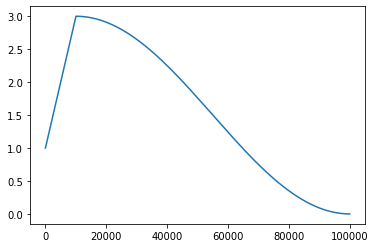

In [ ]:
# lr_scheduler 구성
import torch
import numpy as np

class LR_Scheduler(object):
  def __init__(self, optimizer, warmup_epochs, warmup_lr, num_epochs, base_lr, final_lr, iter_per_epoch, constant_predictor_lr=False):
    self.base_lr = base_lr
    self.constant_predictor_lr = constant_predictor_lr
    warmup_iter = iter_per_epoch * warmup_epochs
    warmup_lr_schedule = np.linspace(warmup_lr, base_lr, warmup_iter)
    decay_iter = iter_per_epoch * (num_epochs - warmup_epochs)
    cosine_lr_schedule = final_lr+0.5*(base_lr-final_lr)*(1+np.cos(np.pi*np.arange(decay_iter)/decay_iter))
    
    self.lr_schedule = np.concatenate((warmup_lr_schedule, cosine_lr_schedule))
    self.optimizer = optimizer
    self.iter = 0
    self.current_lr = 0
  def step(self):
    for param_group in self.optimizer.param_groups:

      if self.constant_predictor_lr and param_group['name'] == 'predictor':
        param_group['lr'] = self.base_lr
      else:
        lr = param_group['lr'] = self.lr_schedule[self.iter]
    
    self.iter += 1
    self.current_lr = lr
    return lr
  def get_lr(self):
    return self.current_lr

if __name__ == "__main__":
  lr_scheduler_model = torchvision.models.resnet50()
  lr_scheduler_optimizer = torch.optim.SGD(lr_scheduler_model.parameters(), lr=999)
  lr_scheduler_epochs = 100
  lr_scheduler_n_iter = 1000
  lr_scheduler = LR_Scheduler(lr_scheduler_optimizer, 10, 1, lr_scheduler_epochs, 3, 0, lr_scheduler_n_iter)
  lr_scheduler_lrs = []
  for epoch in range(lr_scheduler_epochs):
    for it in range(lr_scheduler_n_iter):
      lr_scheduler_lr = lr_scheduler.step()
      lr_scheduler_lrs.append(lr_scheduler_lr)
  plt.plot(lr_scheduler_lrs)
  plt.show()

In [ ]:
# lr_scheduler 선언
main_lr_scheduler = LR_Scheduler(optimizer=main_optimizer, 
                                 warmup_epochs=train_warmup_epochs, 
                                 warmup_lr=train_warmup_lr*batch_size/256, 
                                 num_epochs=train_num_epochs, 
                                 base_lr=train_base_lr*batch_size/256, 
                                 final_lr=train_final_lr*batch_size/256, 
                                 iter_per_epoch=len(train_loader), 
                                 constant_predictor_lr=True
                                 )

In [ ]:
# tensorboard 사용
import torch
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict
import os
import matplotlib
matplotlib.use('Agg') #https://stackoverflow.com/questions/49921721/runtimeerror-main-thread-is-not-in-main-loop-with-matplotlib-and-flask
import matplotlib.pyplot as plt
from torch import Tensor

class Plotter(object):
  def __init__(self):
    self.logger = OrderedDict()
  def update(self, ordered_dict):
    for key, value in ordered_dict.items():
      if isinstance(value, Tensor):
        ordered_dict[key] = value.item()
      if self.logger.get(key) is None:
        self.logger[key] = [value]
      else:
        self.logger[key].append(value)

  def save(self, file, **kwargs):
    fig, axes = plt.subplots(nrows=len(self.logger), ncols=1, figsize=(8,2*len(self.logger)))
    fig.tight_layout()
    for ax, (key, value) in zip(axes, self.logger.items()):
      ax.plot(value)
      ax.set_title(key)

    plt.savefig(file, **kwargs)
    plt.close()

class Logger(object):
  def __init__(self, log_dir, tensorboard=True, matplotlib=True):

    self.reset(log_dir, tensorboard, matplotlib)

  def reset(self, log_dir=None, tensorboard=True, matplotlib=True):

    if log_dir is not None: self.log_dir=log_dir 
    self.writer = SummaryWriter(log_dir=self.log_dir) if tensorboard else None
    self.plotter = Plotter() if matplotlib else None
    self.counter = OrderedDict()

  def update_scalers(self, ordered_dict):

    for key, value in ordered_dict.items():
      if isinstance(value, Tensor):
        ordered_dict[key] = value.item()
      if self.counter.get(key) is None:
        self.counter[key] = 1
      else:
        self.counter[key] += 1

      if self.writer:
        self.writer.add_scalar(key, value, self.counter[key])


    if self.plotter: 
      self.plotter.update(ordered_dict)
      self.plotter.save(os.path.join(self.log_dir, 'plotter.svg'))

In [ ]:
# tensorboard summarywriter 선언
main_logger = Logger(tensorboard = logger_tensorboard, matplotlib=logger_matplotlib, log_dir=log_dir)
main_accuracy=0

KNN monitoring

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F 
import torch
# code copied from https://colab.research.google.com/github/facebookresearch/moco/blob/colab-notebook/colab/moco_cifar10_demo.ipynb#scrollTo=RI1Y8bSImD7N
# test using a knn monitor
def knn_monitor(net, memory_data_loader, test_data_loader, epoch, k=200, t=0.1, hide_progress=False):
  net.eval()
  classes = len(memory_data_loader.dataset.classes)
  total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
  with torch.no_grad():
    # generate feature bank
    for data, target in tqdm(memory_data_loader, desc='Feature extracting', leave=False, disable=hide_progress):
      feature = net(data.cuda(non_blocking=True))
      feature = F.normalize(feature, dim=1)
      feature_bank.append(feature)
    # [D, N]
    feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
    # [N]
    feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
    # loop test data to predict the label by weighted knn search
    test_bar = tqdm(test_data_loader, desc='kNN', disable=hide_progress)
    for data, target in test_bar:
      data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
      feature = net(data)
      feature = F.normalize(feature, dim=1)
      
      pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, k, t)

      total_num += data.size(0)
      total_top1 += (pred_labels[:, 0] == target).float().sum().item()
      test_bar.set_postfix({'Accuracy':total_top1 / total_num * 100})
  return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
  # compute cos similarity between each feature vector and feature bank ---> [B, N]
  sim_matrix = torch.mm(feature, feature_bank)
  # [B, K]
  sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
  # [B, K]
  sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
  sim_weight = (sim_weight / knn_t).exp()

  # counts for each class
  one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
  # [B*K, C]
  one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
  # weighted score ---> [B, C]
  pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

  pred_labels = pred_scores.argsort(dim=-1, descending=True)
  return pred_labels

In [ ]:
# 훈련 시작
from tqdm import tqdm

global_progress = tqdm(range(0, train_stop_at_epoch), desc=f'Training')
for epoch in global_progress:
  main_model_simclr.train()
  
  local_progress=tqdm(train_loader, desc=f'Epoch {epoch}/{train_num_epochs}', disable=hide_progress)
  for idx, (images, labels) in enumerate(local_progress):
    images1, images2 = images

    main_model_simclr.zero_grad()
    data_dict = main_model_simclr.forward(images1.to(device, non_blocking=True), images2.to(device, non_blocking=True))
    loss = data_dict['loss'].mean() # ddp
    loss.backward()
    main_optimizer.step()
    main_lr_scheduler.step()
    data_dict.update({'lr':main_lr_scheduler.get_lr()})
    
    local_progress.set_postfix(data_dict)
    main_logger.update_scalers(data_dict)

  if train_knn_monitor and epoch % train_knn_interval == 0: 
    main_accuracy = knn_monitor(main_model_simclr.module.backbone, memory_loader, test_loader, device, k=min(train_knn_k, len(memory_loader.dataset)), hide_progress=hide_progress) 
  
  epoch_dict = {"epoch":epoch, "accuracy":main_accuracy}
  global_progress.set_postfix(epoch_dict)
  main_logger.update_scalers(epoch_dict)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.



Epoch 8/10:  18%|█▊        | 35/195 [00:46<03:11,  1.20s/it, loss=tensor(5.5295, device='cuda:0', grad_fn=<DivBackward0>), lr=0.246]






Epoch 8/10:  18%|█▊        | 36/195 [00:47<03:08,  1.19s/it, loss=tensor(5.5295, device='cuda:0', grad_fn=<DivBackward0>), lr=0.246]






Epoch 8/10:  18%|█▊        | 36/195 [00:48<03:08,  1.19s/it, loss=tensor(5.6009, device='cuda:0', grad_fn=<DivBackward0>), lr=0.246]






Epoch 8/10:  19%|█▉        | 37/195 [00:48<03:05,  1.18s/it, loss=tensor(5.6009, device='cuda:0', grad_fn=<DivBackward0>), lr=0.246]






Epoch 8/10:  19%|█▉        | 37/195 [00:49<03:05,  1.18s/it, loss=tensor(5.5430, device='cuda:0', grad_fn=<DivBackward0>), lr=0.246]






Epoch 8/10:  19%|█▉        | 38/195 [00:49<03:04,  1.18s/it, loss=tensor(5.5430, device='cuda:0', grad_fn=<DivBackward0>), lr=0.246]






Epoch 8/10:  19%|█▉        | 38/195 [00:50<03:04,  1.18s/it, loss=tensor(5.5641, device='cuda:0', grad_fn=<DivBackward0>), lr=0

In [ ]:
# linear evaluation 설정
class AverageMeter():
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.log = []
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.log.append(self.avg)
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

if __name__ == "__main__":
    am_meter = AverageMeter('sldk')
    print(am_meter.log)

def linear_eval():
  eval_train = torchvision.datasets.CIFAR10(
      root=data_dir, 
      train=True, 
      download=False, 
      transform=Transform_single(size=image_size, train=True), 
      )
  eval_train_loader = torch.utils.data.DataLoader(
      eval_train, 
      shuffle=True,
      batch_size=batch_size,
      num_workers=num_workers,
      drop_last=True,
      pin_memory=True,
      )

  eval_test = torchvision.datasets.CIFAR10(
      root=data_dir, 
      train=False, 
      download=False, 
      transform=Transform_single(size=image_size, train=False), 
      )
  eval_test_loader = torch.utils.data.DataLoader(
      eval_test, 
      shuffle=False,
      batch_size=batch_size,
      num_workers=num_workers,
      drop_last=True,
      pin_memory=True,
      )

  eval_model = eval(f"{model_backbone}()")
  eval_model.output_dim = eval_model.fc.in_features
  eval_model.fc = torch.nn.Identity()
  eval_classifier = nn.Linear(in_features=eval_model.output_dim, out_features=10, bias=True).to(device)

  ###
  assert eval_from is not None
  eval_save_dict = torch.load(eval_from, map_location='cuda')
  eval_msg = eval_model.load_state_dict({k[9:]:v for k, v in eval_save_dict['state_dict'].items() if k.startswith('backbone.')}, strict=True)
  
  print(eval_msg)
  eval_model = eval_model.to(device)
  eval_model = torch.nn.DataParallel(eval_model)

  # if torch.cuda.device_count() > 1: eval_classifier = torch.nn.SyncBatchNorm.convert_sync_batchnorm(eval_classifier)
  eval_classifier = torch.nn.DataParallel(eval_classifier)
  # define optimizer 'sgd', eval_classifier, lr=eval_base_lr=30, momentum=eval_optim_momentum-0.9, weight_decay=eval_optim_weight_decay=0
  predictor_prefix = ('module.predictor', 'predictor')
  parameters = [{
      'name': 'base',
      'params': [param for name, param in eval_classifier.named_parameters() if not name.startswith(predictor_prefix)],
      'lr': eval_base_lr
  },{
      'name': 'predictor',
      'params': [param for name, param in eval_classifier.named_parameters() if name.startswith(predictor_prefix)],
      'lr': eval_base_lr
  }]
  eval_optimizer = torch.optim.SGD(parameters, lr=eval_base_lr, momentum=eval_optim_momentum, weight_decay=eval_optim_weight_decay)

  # define lr scheduler
  eval_lr_scheduler = LR_Scheduler(
      eval_optimizer,
      eval_warmup_epochs, eval_warmup_lr*batch_size/256, 
      eval_num_epochs, eval_base_lr*batch_size/256, eval_final_lr*batch_size/256, 
      len(eval_train_loader),
  )

  eval_loss_meter = AverageMeter(name='Loss')
  eval_acc_meter = AverageMeter(name='Accuracy')

  # Start training
  eval_global_progress = tqdm(range(0, eval_num_epochs), desc=f'Evaluating')
  for epoch in eval_global_progress:
    eval_loss_meter.reset()
    eval_model.eval()
    eval_classifier.train()
    eval_local_progress = tqdm(eval_train_loader, desc=f'Epoch {epoch}/{eval_num_epochs}', disable=True)
    
    for idx, (images, labels) in enumerate(eval_local_progress):

      eval_classifier.zero_grad()
      with torch.no_grad():
        eval_feature = eval_model(images.to(device))

      eval_preds = eval_classifier(eval_feature)

      eval_loss = F.cross_entropy(eval_preds, labels.to(device))

      eval_loss.backward()
      eval_optimizer.step()
      eval_loss_meter.update(eval_loss.item())
      eval_lr = eval_lr_scheduler.step()
      eval_local_progress.set_postfix({'lr':eval_lr, "loss":eval_loss_meter.val, 'loss_avg':eval_loss_meter.avg})

  eval_classifier.eval()
  eval_correct, eval_total = 0, 0
  eval_acc_meter.reset()
  for idx, (images, labels) in enumerate(eval_test_loader):
    with torch.no_grad():
      eval_feature = eval_model(images.to(device))
      eval_preds = eval_classifier(eval_feature).argmax(dim=1)
      eval_correct = (eval_preds == labels.to(device)).sum().item()
      eval_acc_meter.update(eval_correct/eval_preds.shape[0])
  print(f'Accuracy = {eval_acc_meter.avg*100:.2f}')

[]


In [ ]:
# check point 설정 및 Evaluating
from datetime import datetime
import os

if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

main_model_path = os.path.join(ckpt_dir, f"{name}_{datetime.now().strftime('%m%d%H%M%S')}.pth") # datetime.now().strftime('%Y%m%d_%H%M%S')
torch.save({
    'epoch': epoch+1,
    'state_dict':main_model_simclr.module.state_dict()
}, main_model_path)
print(f"Model saved to {main_model_path}")
with open(os.path.join(log_dir, f"checkpoint_path.txt"), 'w+') as f:
  f.write(f'{main_model_path}')

if do_eval is not False:
  eval_from = main_model_path
  linear_eval()

Model saved to ./tmp/simclr-cifar10-experiment_0205114449.pth








Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

<All keys matched successfully>








Evaluating:  10%|█         | 1/10 [00:19<02:53, 19.25s/it]





Evaluating:  20%|██        | 2/10 [00:38<02:34, 19.37s/it]





Evaluating:  30%|███       | 3/10 [00:58<02:15, 19.33s/it]





Evaluating:  40%|████      | 4/10 [01:17<01:56, 19.36s/it]





Evaluating:  50%|█████     | 5/10 [01:37<01:37, 19.41s/it]





Evaluating:  60%|██████    | 6/10 [01:57<01:18, 19.70s/it]





Evaluating:  70%|███████   | 7/10 [02:17<00:59, 19.68s/it]





Evaluating:  80%|████████  | 8/10 [02:36<00:39, 19.56s/it]





Evaluating:  90%|█████████ | 9/10 [02:55<00:19, 19.46s/it]





Evaluating: 100%|██████████| 10/10 [03:14<00:00, 19.47s/it]


Accuracy = 38.70


In [ ]:
#!pip install cairosvg

In [ ]:
import cairosvg

img_dir = './pngs'
if not os.path.exists(img_dir):
  os.makedirs(img_dir)

main_img_path = os.path.join(img_dir, f"{train_optim_name}_{datetime.now().strftime('%m%d%H%M%S')}.png")

cairosvg.svg2png(url='./runs/plotter.svg', write_to=main_img_path, dpi = 100)

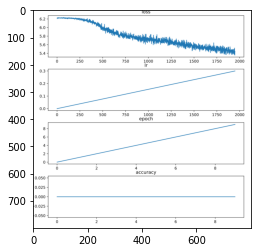

In [ ]:
plotter_image = plt.imread(main_img_path)
plt.imshow(plotter_image)
plt.show()